In [6]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt

from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline

In [7]:
E0 = 500

beta = 1
R = 0.5

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_ 







# Lambert W Tests

Integral of LambertW(x) from 0 to 1:  0.3303661242298211


/tmp/ipykernel_55993/1475809512.py:9: RuntimeWarning: divide by zero encountered in log
  return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))
/tmp/ipykernel_55993/1475809512.py:19: RuntimeWarning: divide by zero encountered in log
  return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_
/tmp/ipykernel_55993/1475809512.py:19: RuntimeWarning: invalid value encountered in multiply
  return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_


Integrals of solved_q(x) from 0 to 1:  [-2.54423556e+12 -2.52793645e+12 -2.51163218e+12 -2.49532274e+12
 -2.47900807e+12 -2.46268813e+12 -2.44636290e+12 -2.43003232e+12
 -2.41369636e+12 -2.39735497e+12 -2.38100811e+12 -2.36465575e+12
 -2.34829782e+12 -2.33193430e+12 -2.31556514e+12 -2.29919028e+12
 -2.28280969e+12 -2.26642331e+12 -2.25003110e+12 -2.23363302e+12
 -2.21722900e+12 -2.20081900e+12 -2.18440297e+12 -2.16798086e+12
 -2.15155261e+12 -2.13511817e+12 -2.11867749e+12 -2.10223051e+12
 -2.08577717e+12 -2.06931742e+12 -2.05285120e+12 -2.03637844e+12
 -2.01989910e+12 -2.00341309e+12 -1.98692038e+12 -1.97042088e+12
 -1.95391453e+12 -1.93740127e+12 -1.92088103e+12 -1.90435375e+12
 -1.88781934e+12 -1.87127775e+12 -1.85472889e+12 -1.83817269e+12
 -1.82160908e+12 -1.80503798e+12 -1.78845930e+12 -1.77187298e+12
 -1.75527893e+12 -1.73867705e+12 -1.72206728e+12 -1.70544952e+12
 -1.68882367e+12 -1.67218966e+12 -1.65554738e+12 -1.63889674e+12
 -1.62223765e+12 -1.60557000e+12 -1.58889369e+12 -1

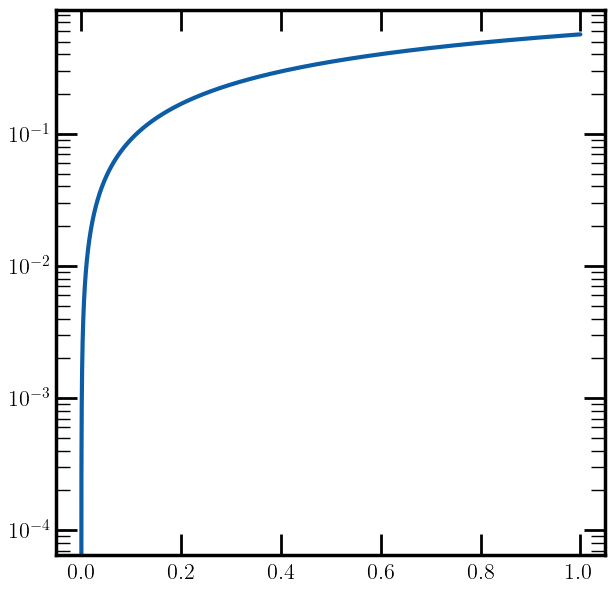

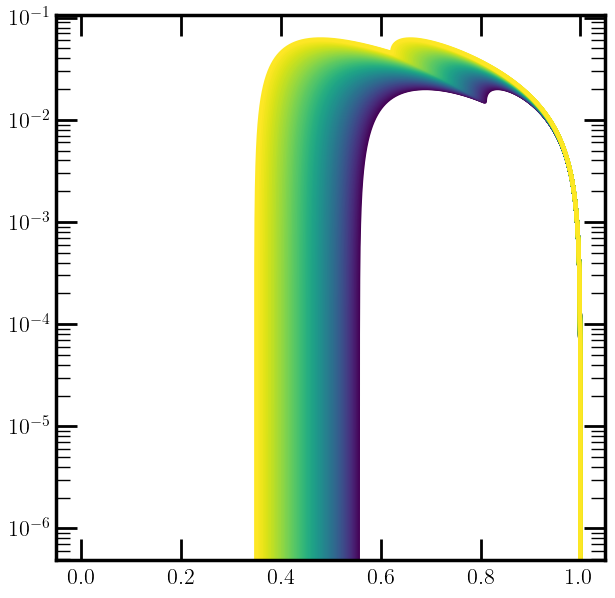

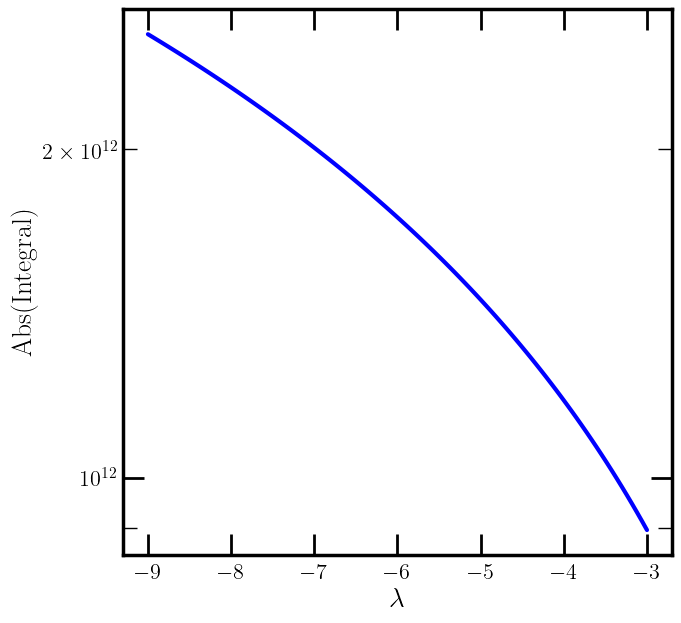

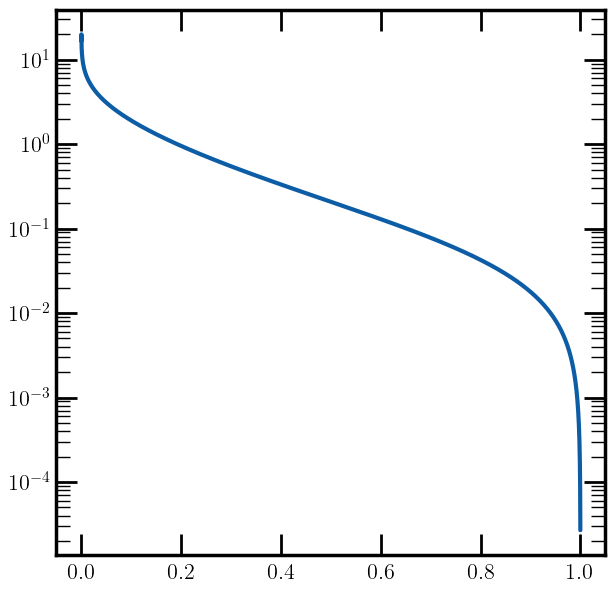

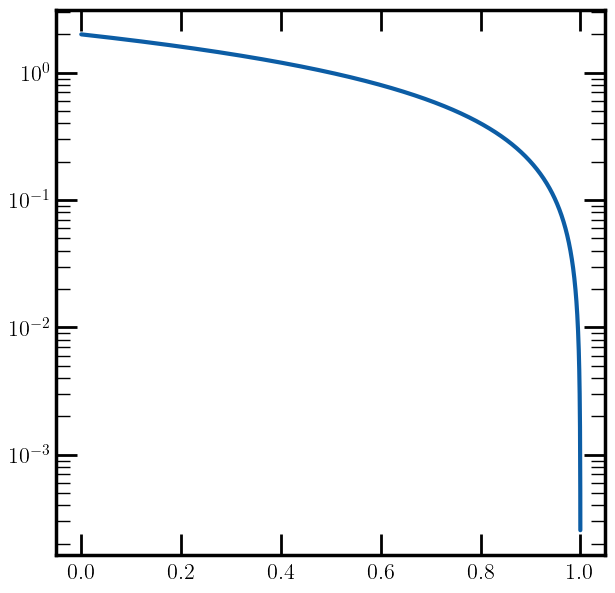

In [28]:
def p(x):
    return LO_angularity(x) 


def solved_q(x, lambda_ = None):

    p_x = p(x)
    q = p_x * np.exp(lambertw(lambda_ * p_x))

    return np.nan_to_num(q)





# Plot the LambertW function
fig, ax = newplot("full")
x = np.linspace(0, 1, 10000)
y = lambertw(x)
ax.plot(x, y.real)
ax.set_yscale("log")
integral = np.trapz(y.real, x)
print("Integral of LambertW(x) from 0 to 1: ", integral)

# Plot the LambertW function
fig, ax = newplot("full")
x = np.linspace(0, 1, 10000)
lambdas = np.logspace(-9, -3, 100)
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
integrals = []
for lambda_ in lambdas:
    y = solved_q(x, lambda_)
    ax.plot(x, y.real, label=f"$\lambda$ = {lambda_}", color=colors[np.where(lambdas == lambda_)[0][0]])
    integral = np.trapz(y.real, x)
    integrals.append(integral)
ax.set_yscale("log")


# Plot the integrals
fig, ax = newplot("full")
integrals = np.array(integrals)
signed_color = (np.sign(integrals) + 1) / 2
ax.plot(lambdas[integrals > 0], np.abs(integrals[integrals > 0]), color = "red")
ax.plot(lambdas[integrals < 0], np.abs(integrals[integrals < 0]), color = "blue")

ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Abs(Integral)")
print("Integrals of solved_q(x) from 0 to 1: ", integrals)





fig, ax = newplot("full")
x = np.sort(np.random.rand(10000))
y = np.nan_to_num(lambertw(LO_angularity(x) / 2) * 2)
ax.plot(x, y.real)
ax.set_yscale("log")
integral = np.trapz(y.real, x)
print("Integral of LambertW(LO_angularity(x)) from 0 to 1: ", integral)


fig, ax = newplot("full")
x = np.sort(np.random.rand(10000))
y = np.nan_to_num(2 - 2*x)
ax.plot(x, y.real)
ax.set_yscale("log")
integral = np.trapz(y.real, x)
print("Integral of LambertW(LO_angularity(x)) from 0 to 1: ", integral)

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_x(x):
    return -np.log(x) / x

p_x = LO_angularity

def C(x, c = 0.5, temp = 0.001):

    return sigmoid((x - c) / temp) - sigmoid((0 - c) / temp)



def ReLU(x):
    return np.maximum(0, x)

N_samples = 100000
x = np.random.uniform(0, 1, N_samples)

def answer(p, C, x, lambda_ = None, c = 0.5):

    # log MSE
    arg = lambda_ * p(x) / (2 * C(x, c) )
    q = p(x) * np.exp(lambertw(-arg))
    return(q)

    # ratio MSE
    return ReLU(p(x) - p(x)**2 * lambda_ / (2 * C(x, c)))


def integral(p, C, x, lambda_ = None, c = 0.5):

    ans = answer(p, C, x, lambda_, c)
    return np.mean(ans)

def find_lambda(c = 0.5):

    tolerance = 1e-5

    max_lambda = 2 * C(x, c) * p_x(x)

    # Take the minimum of the max_lambda
    max_lambda = np.max(max_lambda) 
    min_lambda = - max_lambda

    s_max = integral(p_x, C, x, max_lambda, c)
    s_min = integral(p_x, C, x, min_lambda, c)

    mid_lambda = (max_lambda + min_lambda) / 2 
    s_mid = integral(p_x, C, x, mid_lambda, c)

    while np.abs(s_mid - 1) > tolerance:
        if s_mid > 1:
            min_lambda = mid_lambda
        else:
            max_lambda = mid_lambda

        mid_lambda = (max_lambda + min_lambda) / 2
        s_mid = integral(p_x, C, x, mid_lambda, c)

    return mid_lambda


In [18]:
print(np.sort(x))

[2.84060859e-06 5.65613336e-06 9.13602286e-06 ... 9.99973783e-01
 9.99977674e-01 9.99981091e-01]


/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


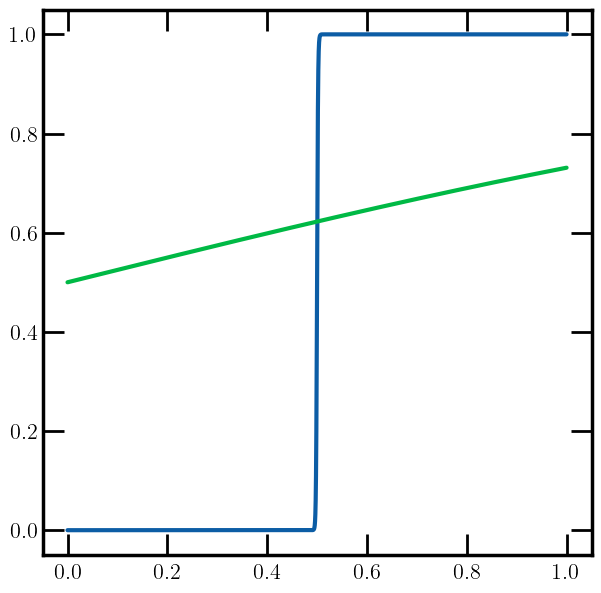

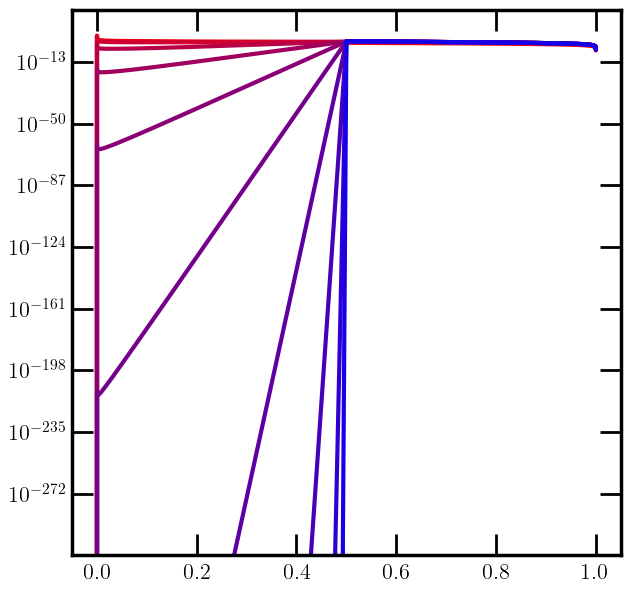

In [19]:
fig, ax = newplot("full")
x_sorted = np.sort(x)
ax.plot(x_sorted, C(x_sorted), label = "C(x)")
ax.plot(x_sorted, sigmoid(x_sorted), label = "p(x)")
# ax.plot(x_sorted, p_x(x_sorted), label = "p(x)")


fig, ax = newplot("full")
for (i,temp) in enumerate(np.logspace(-5, 0, 11)[::-1]):

    # warm to cool color
    n = 11
    color = (1 - i/n, 0, i/n)
   
    ratio = p_x(x_sorted) * C(x_sorted, temp=temp)
    ax.plot(x_sorted, ratio, label = "p(x) / C(x)", color = color)
    ax.set_yscale("log")
    # ax.set_xscale("log")

/tmp/ipykernel_41882/1778562690.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1.0 (nan+nanj)
0.9500000000000001 (nan+nanj)
0.9 (nan+nanj)
0.8500000000000001 (nan+nanj)
0.8 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.75 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: overflow encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


0.7000000000000001 (nan+nanj)
0.65 (1.0000011023828201+0j)
0.6000000000000001 (1.0000010430165172+0j)
0.55 (1.000000067766714+0j)
0.5 (0.9999923433580343+0j)
0.45 (0.999996810772149+0j)
0.4 (1.0000079555685772+0j)
0.35000000000000003 (0.9999926402719669+0j)
0.30000000000000004 (1.000002081087113+0j)
0.25 (0.9999935603661021+0j)
0.2 (1.000008895750912+0j)
0.15000000000000002 (1.000007833680995+0j)
0.1 (0.9999929037704902+0j)
0.05 (1.0000030395800272+0j)
0.0 (0.9999975458017575+0j)


(0.001, 1000.0)

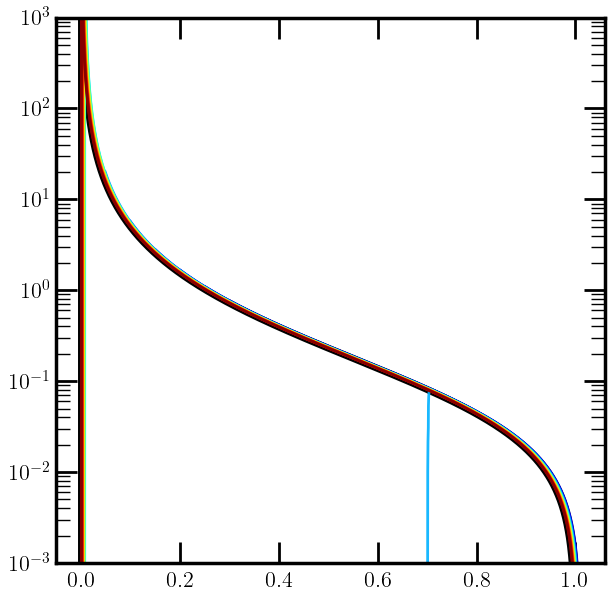

In [20]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

fig, ax = newplot("full")

ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 5)


cs = np.linspace(0, 1.0, 21)[::-1]
colors = get_cmap("jet")

for c in cs:




    lambda_ = find_lambda(c)
    ax.plot(x_sorted + c / 100, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 0.9, lw = 2)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

ax.set_ylim(1e-3, 1e3)

In [21]:
c = 0.5
lambda_ = find_lambda(c)
a = (answer(p_x, C, x_sorted, lambda_, c))
print(c, integral(p_x, C, x, lambda_, c))
print(a)

0.5 (0.9999923433580343+0j)
[-2.07363886e+06+0.j -7.76641091e+05+0.j -4.52359659e+05+0.j ...
  3.97155104e-06+0.j  3.38200574e-06+0.j  2.86436029e-06+0.j]


/tmp/ipykernel_41882/1493205528.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.0 (0.9999975458017575+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.05 (1.0000030395800272+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.1 (0.9999929037704902+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.15000000000000002 (1.000007833680995+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.2 (1.000008895750912+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.25 (0.9999935603661021+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.30000000000000004 (1.000002081087113+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.35000000000000003 (0.9999926402719669+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.4 (1.0000079555685772+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.45 (0.999996810772149+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.5 (0.9999923433580343+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.55 (1.000000067766714+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.6000000000000001 (1.0000010430165172+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.65 (1.0000011023828201+0j)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: overflow encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.7000000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.75 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.8 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py

0.8500000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/rikabplotlib/plot_utils.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplo

0.9500000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1.0 (nan+nanj)


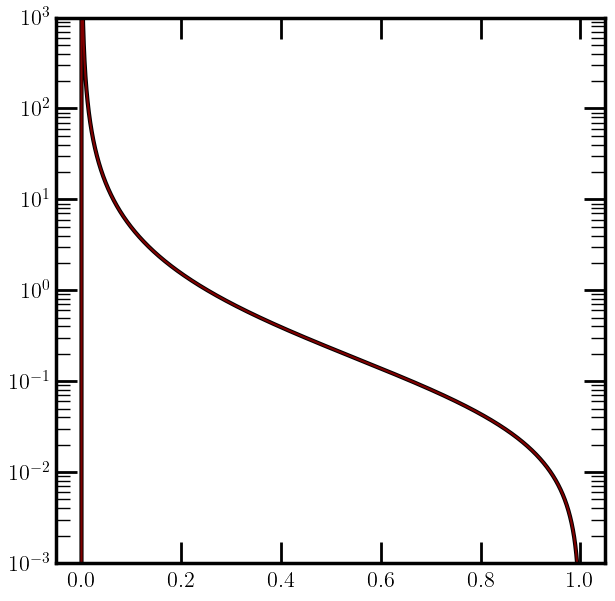

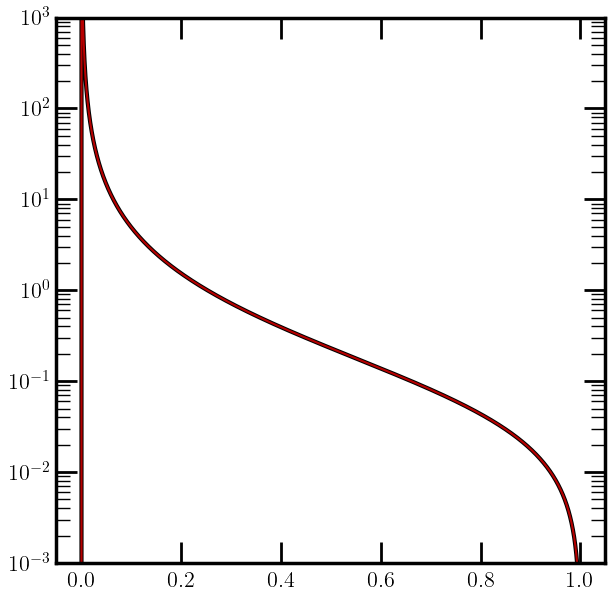

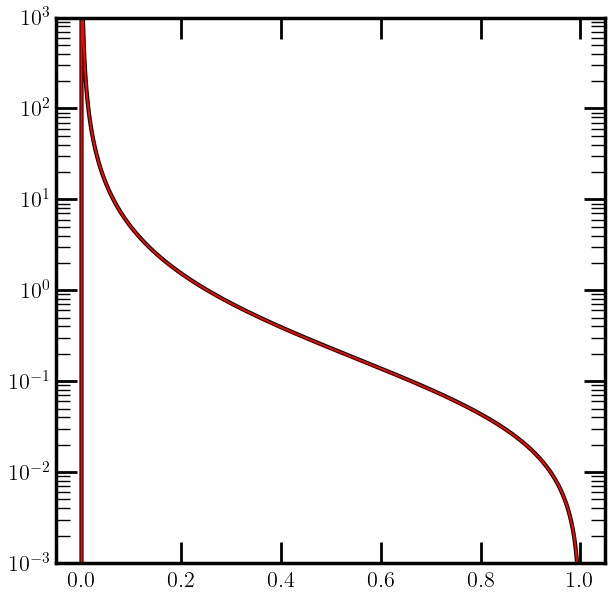

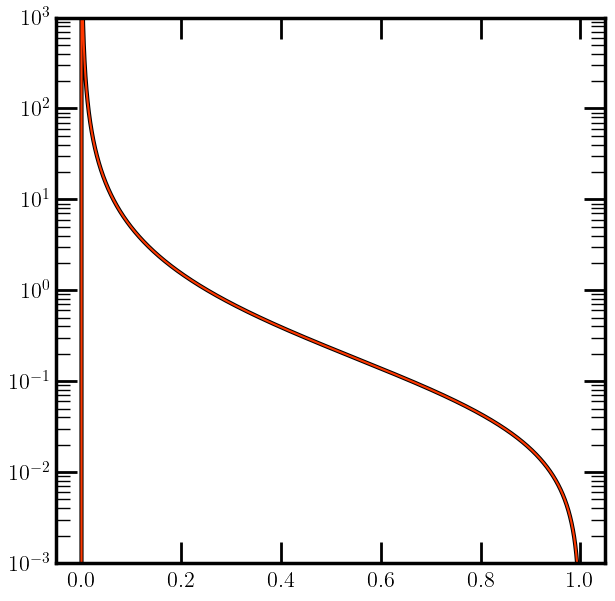

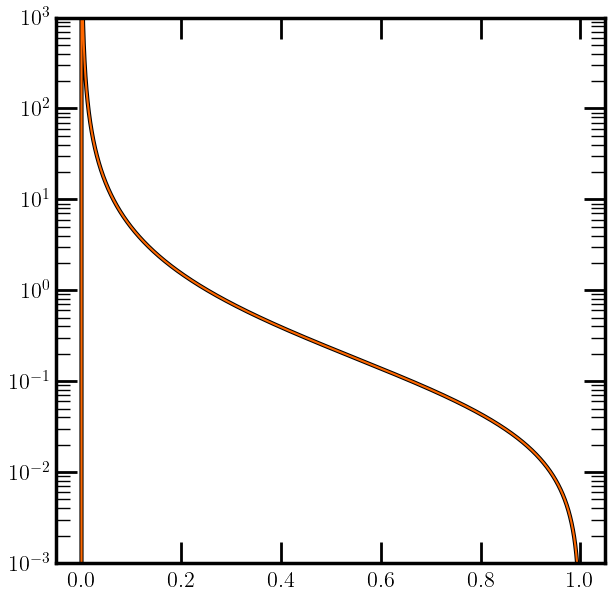

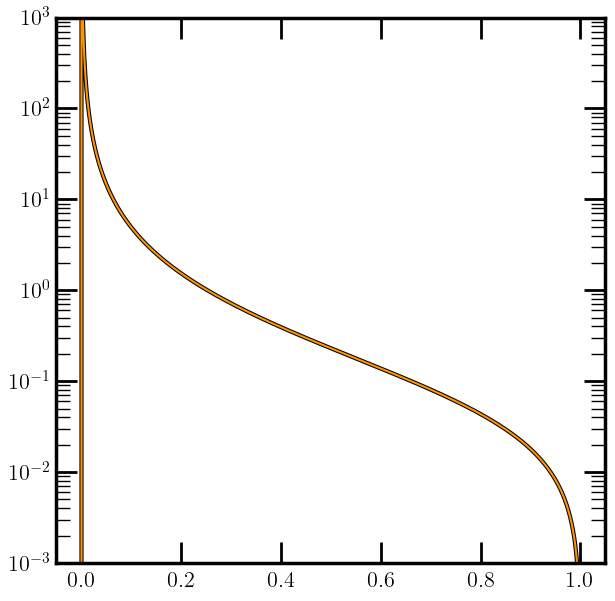

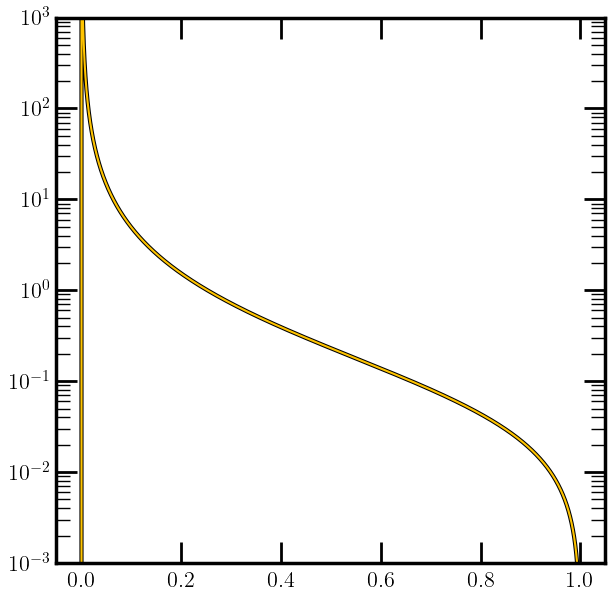

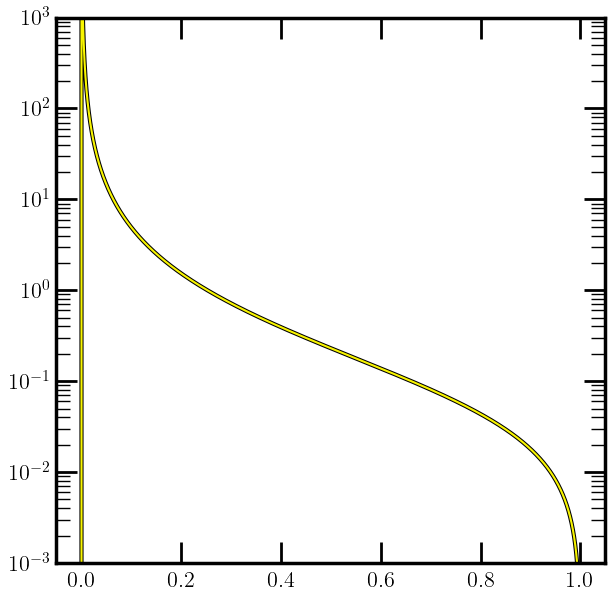

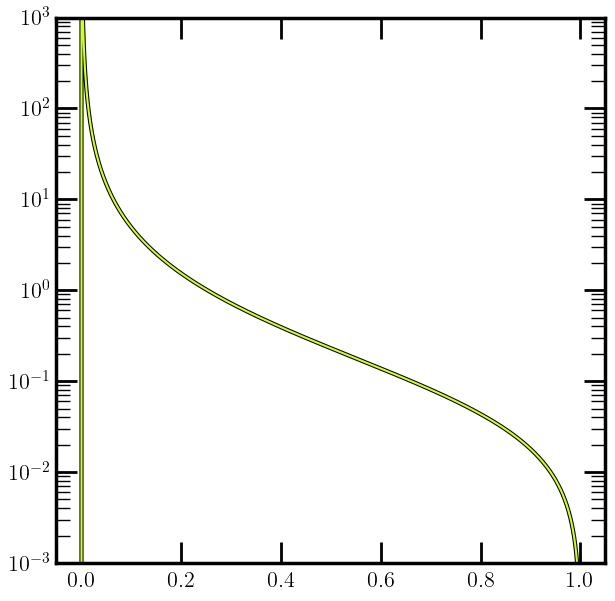

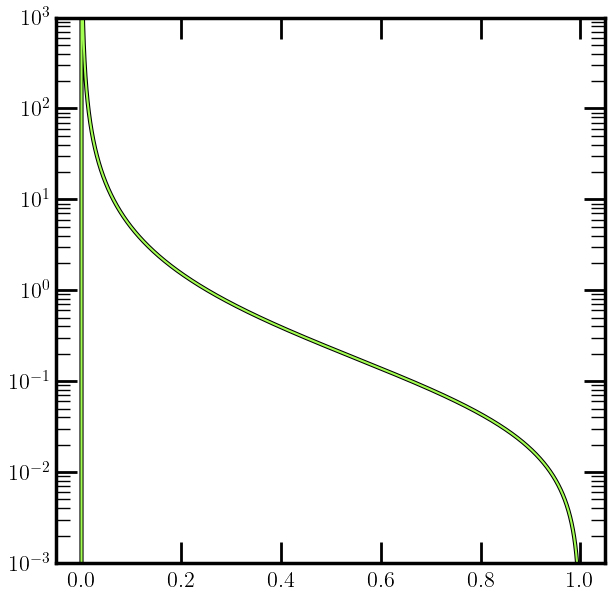

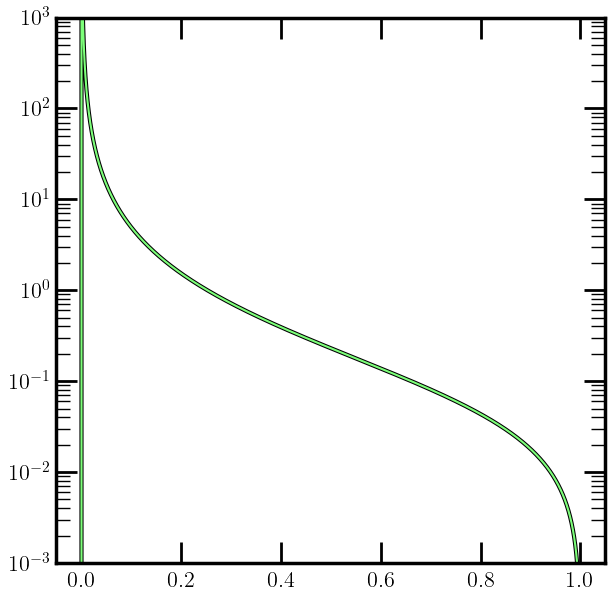

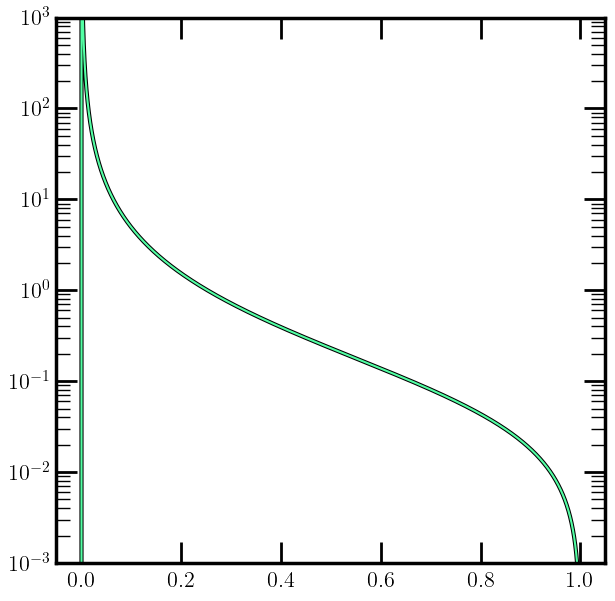

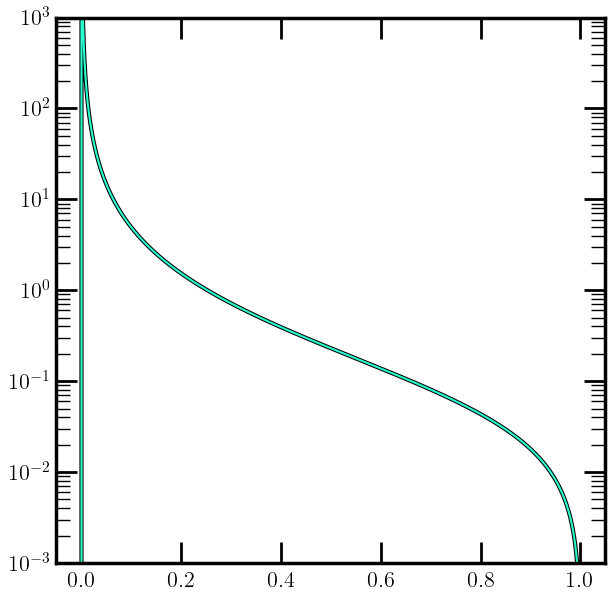

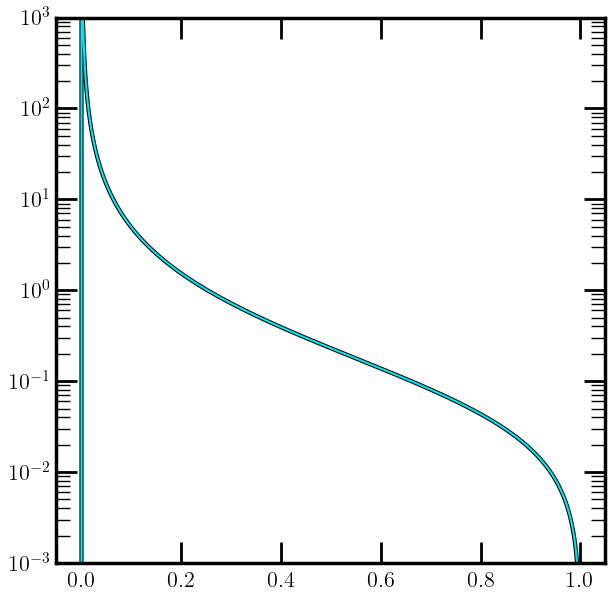

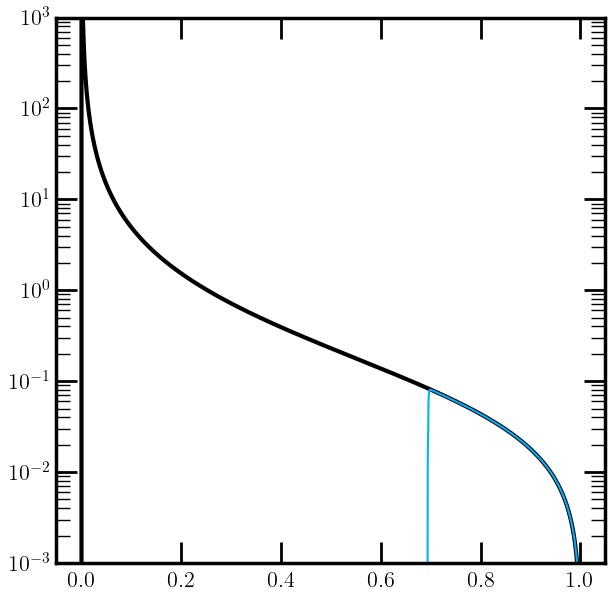

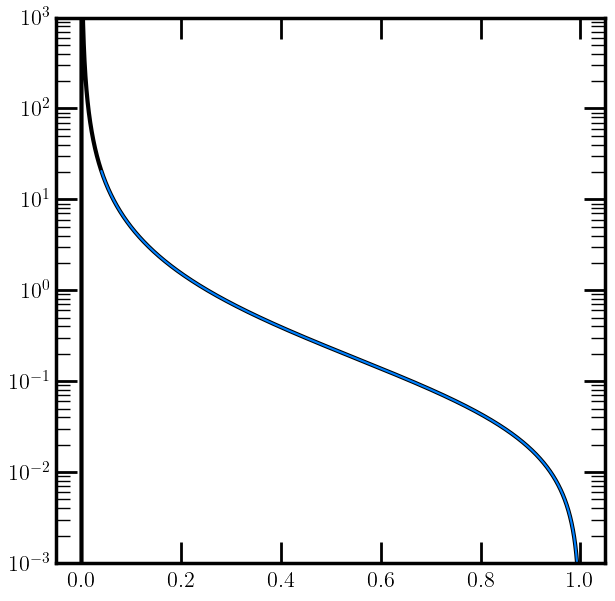

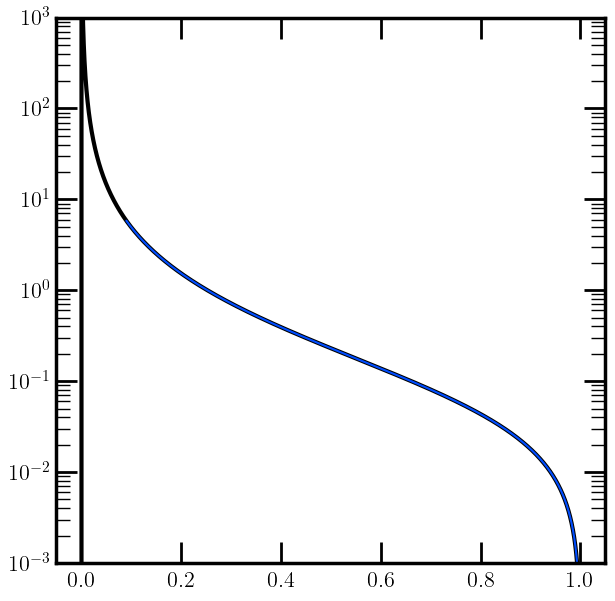

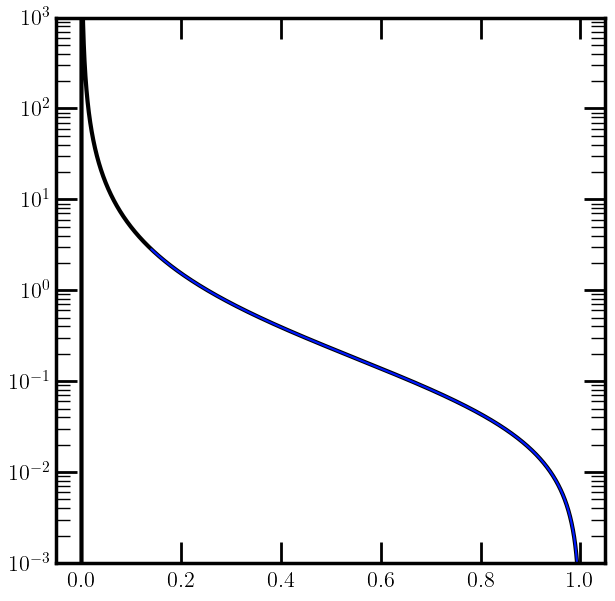

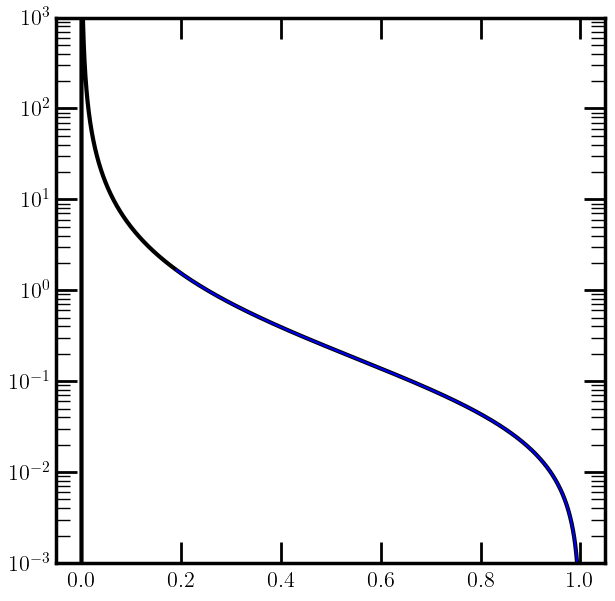

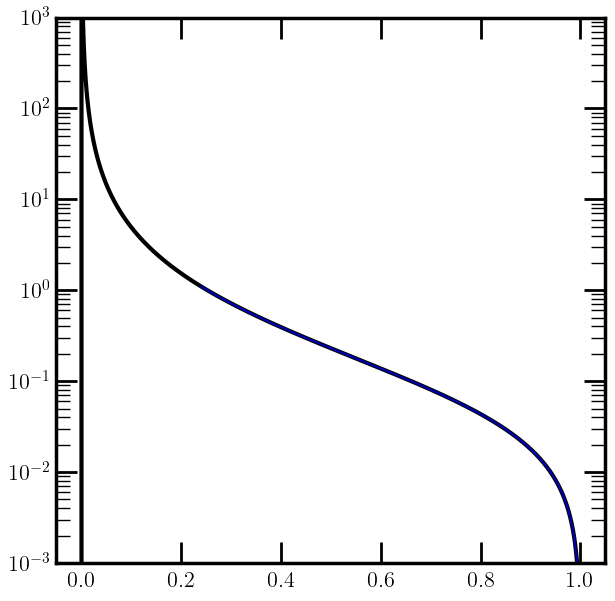

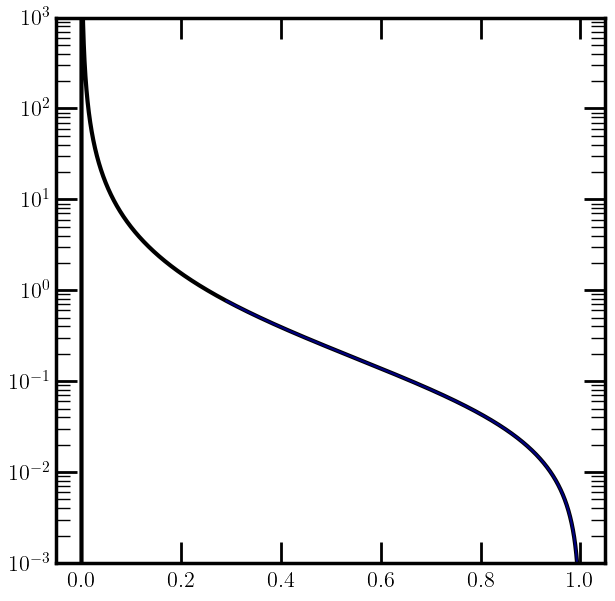

In [22]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


cs = np.linspace(0, 1.0, 21)
colors = get_cmap("jet")

for c in cs:

    fig, ax = newplot("full")

    ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 3)




    lambda_ = find_lambda(c)
    ax.plot(x_sorted, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 1, lw = 1.5)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

    ax.set_ylim(1e-3, 1e3)